# Desafio 6

Neste desafio, vamos praticar _feature engineering_, um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from glob import glob
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import (
    OneHotEncoder, Binarizer, KBinsDiscretizer,
    MinMaxScaler, StandardScaler, PolynomialFeatures
)
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfTransformer, TfidfVectorizer
)

In [2]:
# Algumas configurações para o matplotlib.
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [3]:
countries = pd.read_csv(glob("data/*")[0])

In [4]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

countries.columns = new_column_names

countries.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


## Observações

Esse _data set_ ainda precisa de alguns ajustes iniciais. Primeiro, note que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Corrija isso antes de continuar: transforme essas variáveis em numéricas adequadamente.

Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Você pode utilizar o método `str.strip()` para remover esses espaços.

## Inicia sua análise a partir daqui

In [5]:
# Sua análise começa aqui.

countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country           227 non-null    object 
 1   Region            227 non-null    object 
 2   Population        227 non-null    int64  
 3   Area              227 non-null    int64  
 4   Pop_density       227 non-null    object 
 5   Coastline_ratio   227 non-null    object 
 6   Net_migration     224 non-null    object 
 7   Infant_mortality  224 non-null    object 
 8   GDP               226 non-null    float64
 9   Literacy          209 non-null    object 
 10  Phones_per_1000   223 non-null    object 
 11  Arable            225 non-null    object 
 12  Crops             225 non-null    object 
 13  Other             225 non-null    object 
 14  Climate           205 non-null    object 
 15  Birthrate         224 non-null    object 
 16  Deathrate         223 non-null    object 
 1

## Questão 1

Quais são as regiões (variável `Region`) presentes no _data set_? Retorne uma lista com as regiões únicas do _data set_ com os espaços à frente e atrás da string removidos (mas mantenha pontuação: ponto, hífen etc) e ordenadas em ordem alfabética.

In [6]:
# Tirando os espaços em bracos com o strip
countries['Region']=countries['Region'].str.strip(' ')

In [7]:
countries.columns

Index(['Country', 'Region', 'Population', 'Area', 'Pop_density',
       'Coastline_ratio', 'Net_migration', 'Infant_mortality', 'GDP',
       'Literacy', 'Phones_per_1000', 'Arable', 'Crops', 'Other', 'Climate',
       'Birthrate', 'Deathrate', 'Agriculture', 'Industry', 'Service'],
      dtype='object')

In [8]:
def q1():
    # Pegando apenas as regiões diferentes entre si.
    return sorted(countries['Region'].unique())
q1()

['ASIA (EX. NEAR EAST)',
 'BALTICS',
 'C.W. OF IND. STATES',
 'EASTERN EUROPE',
 'LATIN AMER. & CARIB',
 'NEAR EAST',
 'NORTHERN AFRICA',
 'NORTHERN AMERICA',
 'OCEANIA',
 'SUB-SAHARAN AFRICA',
 'WESTERN EUROPE']

## Questão 2

Discretizando a variável `Pop_density` em 10 intervalos com `KBinsDiscretizer`, seguindo o encode `ordinal` e estratégia `quantile`, quantos países se encontram acima do 90º percentil? Responda como um único escalar inteiro.

In [9]:
to_numeric=['Pop_density', 'Coastline_ratio', 'Net_migration', 'Infant_mortality',
 'Literacy', 'Phones_per_1000', 'Arable', 'Crops', 'Other', 'Climate',
  'Birthrate', 'Deathrate', 'Agriculture', 'Industry', 'Service']

In [10]:
# Convertendo  de objeto para float todas as colunas de `to_numeric`
for x in to_numeric:
    countries[x]=countries[x].str.replace(',','.').astype(np.float)

In [11]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country           227 non-null    object 
 1   Region            227 non-null    object 
 2   Population        227 non-null    int64  
 3   Area              227 non-null    int64  
 4   Pop_density       227 non-null    float64
 5   Coastline_ratio   227 non-null    float64
 6   Net_migration     224 non-null    float64
 7   Infant_mortality  224 non-null    float64
 8   GDP               226 non-null    float64
 9   Literacy          209 non-null    float64
 10  Phones_per_1000   223 non-null    float64
 11  Arable            225 non-null    float64
 12  Crops             225 non-null    float64
 13  Other             225 non-null    float64
 14  Climate           205 non-null    float64
 15  Birthrate         224 non-null    float64
 16  Deathrate         223 non-null    float64
 1

In [12]:
def q2():
    # Retorne aqui o resultado da questão 2.
    
    # Instanciando KbinsDicretizer
    kb_discretizer=KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
    
    # Treinando e transformando os dados.
    pop_density_ordinal=kb_discretizer.fit_transform(countries[['Pop_density']])
    
    # Pegando os dados os valores maiores ou iguais a  9
    pop_density_ordinal=pop_density_ordinal.flatten()>=9.0
    return (int(pop_density_ordinal.sum()))
q2()

23

# Questão 3

Se codificarmos as variáveis `Region` e `Climate` usando _one-hot encoding_, quantos novos atributos seriam criados? Responda como um único escalar.

In [13]:
def q3():
    # Retorne aqui o resultado da questão 3.
    region_unique=countries["Region"].nunique(dropna=False)
    clima_unique=countries["Climate"].nunique(dropna=False)
    return region_unique+clima_unique
q3()

18

## Questão 4

Aplique o seguinte _pipeline_:

1. Preencha as variáveis do tipo `int64` e `float64` com suas respectivas medianas.
2. Padronize essas variáveis.

Após aplicado o _pipeline_ descrito acima aos dados (somente nas variáveis dos tipos especificados), aplique o mesmo _pipeline_ (ou `ColumnTransformer`) ao dado abaixo. Qual o valor da variável `Arable` após o _pipeline_? Responda como um único float arredondado para três casas decimais.

In [14]:
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]

In [15]:
num_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("standardize", StandardScaler())])
val_pipeline=num_pipeline.fit_transform(countries[['Area','Population','GDP']])

In [16]:
teste=pd.DataFrame([test_country],columns = countries.columns)

In [17]:
def q4():
    # Retorne aqui o resultado da questão 4.
    
    # Instanciando a Pipeline com instâncias de  SimpleImputer,que irá colocar a mediana nos NaN
    # E com as instancia de StandardScalar que irá padronizar os dados
    pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(missing_values=np.nan,strategy="median")),
    ("standardize", StandardScaler())])
    
    # Transfomando o vetor em um DataFrame
    df_test = pd.DataFrame([test_country],columns = countries.columns)
    
    # Treinando os dados com apenas os valores numéricos de countries
    pipeline.fit(countries._get_numeric_data())
    
    # Transformando(imputando e padronizando) os dados numérido de df_test
    df_test_transform=pipeline.transform(df_test._get_numeric_data())
    
    # Transformando o vetor em Dataframe
    df_test_transform = pd.DataFrame(df_test_transform,columns = df_test._get_numeric_data().columns)
    
    return round(df_test_transform.loc[0,'Arable'],3)
q4()   

-1.047

## Questão 5

Descubra o número de _outliers_ da variável `Net_migration` segundo o método do _boxplot_, ou seja, usando a lógica:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ é outlier}$$

que se encontram no grupo inferior e no grupo superior.

Você deveria remover da análise as observações consideradas _outliers_ segundo esse método? Responda como uma tupla de três elementos `(outliers_abaixo, outliers_acima, removeria?)` ((int, int, bool)).

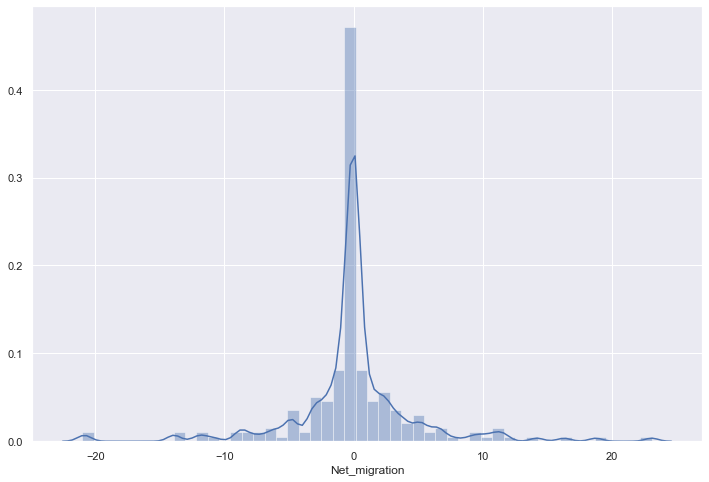

In [18]:
sns.distplot(countries['Net_migration'])

C:\Users\Nair Marinho\anaconda3\lib\site-packages\seaborn\categorical.py:1326: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\Nair Marinho\anaconda3\lib\site-packages\seaborn\categorical.py:1330: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


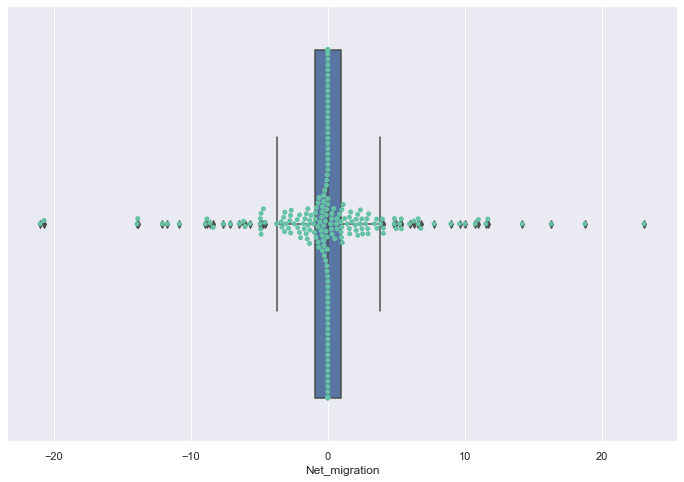

In [19]:
sns.boxplot(x=countries['Net_migration'])
sns.swarmplot(x=countries['Net_migration'], palette="Set2");

In [20]:
def q5():
    # Retorne aqui o resultado da questão 4.
    q1=countries['Net_migration'].quantile(0.25)
    q3=countries['Net_migration'].quantile(0.75)
    diq = q3-q1
    interval = [q1 -1.5*diq,q3 +1.5*diq]
    outliers_abaixo = countries['Net_migration'] <interval[0]
    outliers_acima = countries['Net_migration'] >interval[1]
    return tuple([outliers_abaixo.sum(),outliers_acima.sum(),False])
q5()

(24, 26, False)

## Questão 6
Para as questões 6 e 7 utilize a biblioteca `fetch_20newsgroups` de datasets de test do `sklearn`

Considere carregar as seguintes categorias e o dataset `newsgroups`:

```
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
```


Aplique `CountVectorizer` ao _data set_ `newsgroups` e descubra o número de vezes que a palavra _phone_ aparece no corpus. Responda como um único escalar.

In [21]:
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)

In [22]:
def q6():
    # Retorne aqui o resultado da questão 4.
    count_vector = CountVectorizer()
    recebedor=count_vector.fit_transform(newsgroup.data)
    return int(recebedor[:,count_vector.vocabulary_['phone']].sum())
q6()

213

## Questão 7

Aplique `TfidfVectorizer` ao _data set_ `newsgroups` e descubra o TF-IDF da palavra _phone_. Responda como um único escalar arredondado para três casas decimais.

In [23]:
def q7():
    # Retorne aqui o resultado da questão 4.
    tfid_vector=TfidfVectorizer()
    recebedor= tfid_vector.fit_transform(newsgroup.data)
    return float(round(recebedor[:,tfid_vector.vocabulary_['phone']].sum(),3))
q7()

8.888